In [1]:
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/cyrilic")

In [2]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import random
import os

from PIL import ImageFile
from tqdm import tqdm
import h5py
import cv2

import matplotlib.pylab as plt
from matplotlib import cm
%matplotlib inline

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from keras.utils import to_categorical
from keras.preprocessing import image as keras_image
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.metrics import top_k_categorical_accuracy,categorical_accuracy

from keras.models import Sequential, load_model, Model
from keras.layers import Input, BatchNormalization
from keras.layers import Dense, LSTM, GlobalAveragePooling1D, GlobalAveragePooling2D
from keras.layers import Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.layers.advanced_activations import PReLU, LeakyReLU

from keras.applications.inception_v3 import InceptionV3, preprocess_input
import scipy
from scipy import misc

import warnings
warnings.filterwarnings('ignore')

In [3]:
!ls

 archive.zip			 background	   images
'archive.zip (Unzipped Files)'	'encoded labels'   kirilica


In [4]:
disk_folder="kirilica"
folder='kirilica/'

Loading the dataframe containing the information about the images

In [5]:
data_info =  ['letters.csv', 'letters2.csv', 'letters3.csv']

In [6]:
def import_data(data_info):

  """Creates an additional column: the path to the image"""
  data = pd.read_csv(disk_folder + '/' + data_info)
  data['file'] = data_info[:-4]+'/' + data['file']
  return data

In [7]:
letters = [import_data(file) for file in data_info]
data = pd.concat(letters, ignore_index=True)

In [8]:
data = shuffle(data, random_state = 42)

In [9]:
data.head(3)

,letter,label,file,background
6491,щ,27,letters2/27_212.png,2
2012,в,3,letters2/03_53.png,2
13295,ы,29,letters3/29_336.png,3


Target preprocessing

In [10]:
# Get all labels in one string
print("".join(sorted(data.letter.unique())))
letters = '' 
for letter in data.letter.unique():
    letters += letter
    
# Which letter is written on each image
labels = data.label



абвгдежзийклмнопрстуфхцчшщъыьэюяё


In [11]:
def ohe_letter(label):
    result = np.zeros(len(letters))
    index = letters.index(label)
    result[index] = 1
    return result

def ohe_background(label):
    result = np.zeros(len(data.background.unique()))
    result[label] = 1
    return result

In [12]:
data['enc_label'] = to_categorical(data['label'].values).tolist()
data['enc_background'] = to_categorical(data['background'].values).tolist()
data.head()


,letter,label,file,background,enc_label,enc_background
6491,щ,27,letters2/27_212.png,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0]"
2012,в,3,letters2/03_53.png,2,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0]"
13295,ы,29,letters3/29_336.png,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0]"
11270,с,19,letters3/19_311.png,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0]"
12837,щ,27,letters3/27_278.png,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0]"


Image preprocessing

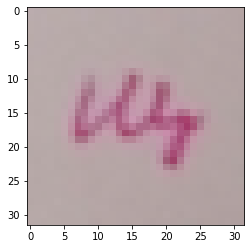

In [13]:
# set the image size
img_width, img_height = 32, 32
input_shape = (img_width, img_height, 3)

# let's look at one of the images
image_file_name = folder + 'letters2/27_212.png'
img = image.load_img(image_file_name, target_size=(img_width, img_height))
plt.imshow(img)

In [14]:
images = []

# Will be the target
encoded_labels = []

backgrounds = []
encoded_backgrounds = []

# Want to be sure that every image is consitent
j = 1
for i, row in data.iterrows():
    print(f'Processing image {j}')
    j += 1
    img_name = row['file']
    numpy_image = cv2.imread(folder + img_name)
    if numpy_image.shape == (32, 32, 3):
        images.append(numpy_image)
        encoded_labels.append(row['enc_label'])
        backgrounds.append(row['background'])
        encoded_backgrounds.append(row['enc_background'])
        
# Normalize array of images
images = np.array(images)/255

Streaming output truncated to the last 5000 lines.
Processing image 9191
Processing image 9192
Processing image 9193
Processing image 9194
Processing image 9195
Processing image 9196
Processing image 9197
Processing image 9198
Processing image 9199
Processing image 9200
Processing image 9201
Processing image 9202
Processing image 9203
Processing image 9204
Processing image 9205
Processing image 9206
Processing image 9207
Processing image 9208
Processing image 9209
Processing image 9210
Processing image 9211
Processing image 9212
Processing image 9213
Processing image 9214
Processing image 9215
Processing image 9216
Processing image 9217
Processing image 9218
Processing image 9219
Processing image 9220
Processing image 9221
Processing image 9222
Processing image 9223
Processing image 9224
Processing image 9225
Processing image 9226
Processing image 9227
Processing image 9228
Processing image 9229
Processing image 9230
Processing image 9231
Processing image 9232
Processing image 9233
Pro

In [15]:
len(images), len(encoded_labels)

(14178, 14178)

In [16]:
import pickle as pkl
filename = 'images'
fileObject = open(filename, 'wb')
pkl.dump(images, fileObject)
fileObject.close()

filename = 'encoded labels'
fileObject = open(filename, 'wb')
pkl.dump(np.array(encoded_labels), fileObject)
fileObject.close()

filename = 'background'
fileObject = open(filename, 'wb')
pkl.dump(np.array(backgrounds), fileObject)
fileObject.close()

filename = 'encoded_backgrounds'
fileObject = open(filename, 'wb')
pkl.dump(np.array(encoded_backgrounds), fileObject)
fileObject.close()

In [17]:
!ls

 archive.zip			 encoded_backgrounds   kirilica
'archive.zip (Unzipped Files)'	'encoded labels'
 background			 images


Creating train and test sets

In [19]:
X = np.array(images.copy())
y = np.array(encoded_labels.copy())

# Stratified train_test split on labels
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=.2, 
                                                  stratify = y, 
                                                  random_state=42)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((11342, 32, 32, 3), (2836, 32, 32, 3), (11342, 34), (2836, 34))

In [20]:
datagen = ImageDataGenerator(rescale=1. / 255,
                              rotation_range=40,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              zoom_range=0.2,
                              horizontal_flip=True,
                              fill_mode='nearest')
datagen.fit(X_train)

Configuring of CNN

In [21]:
# The shape of input tensors
input_shape = (img_width, img_height, 3)

# Number of classes to consider
num_classes = len(letters)

# Group of training samples
batch_size = 64

# Number of complete presentations of the dataset to be learned
epochs = 100

In [68]:
model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), activation = 'relu', input_shape = input_shape))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(Conv2D(128, (4, 4), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes+1, activation = 'softmax'))


# Compile the model
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 25, 25, 128)       131200    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 12, 12, 128)       0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)              

In [69]:
lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                 patience=10, 
                                 verbose=2, 
                                 factor=.75)


model_checkpoint= ModelCheckpoint("/best_result_checkpoint_cyrilic", monitor='val_loss', save_best_only=True, verbose=0)

In [70]:
model.fit(X_train, y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose = 1,
                    validation_data = (X_val, y_val),
                    callbacks = [model_checkpoint, lr_reduction])

Epoch 1/100
178/178 [==============================] - 5s 24ms/step - loss: 3.5130 - accuracy: 0.0316 - val_loss: 3.2490 - val_accuracy: 0.1178
INFO:tensorflow:Assets written to: /best_result_checkpoint_cyrilic/assets
Epoch 2/100
178/178 [==============================] - 4s 22ms/step - loss: 3.0201 - accuracy: 0.1570 - val_loss: 2.1154 - val_accuracy: 0.4489
INFO:tensorflow:Assets written to: /best_result_checkpoint_cyrilic/assets
Epoch 3/100
178/178 [==============================] - 4s 22ms/step - loss: 2.1660 - accuracy: 0.3690 - val_loss: 1.5854 - val_accuracy: 0.5568
INFO:tensorflow:Assets written to: /best_result_checkpoint_cyrilic/assets
Epoch 4/100
178/178 [==============================] - 4s 22ms/step - loss: 1.7358 - accuracy: 0.4879 - val_loss: 1.3610 - val_accuracy: 0.6181
INFO:tensorflow:Assets written to: /best_result_checkpoint_cyrilic/assets
Epoch 5/100
178/178 [==============================] - 4s 22ms/step - loss: 1.5100 - accuracy: 0.5493 - val_loss: 1.1501 - val_a

In [71]:
!cp -r /best_result_checkpoint_cyrilic  '/content/drive/My Drive/Colab Notebooks/cyrilic'

In [72]:
cnn_model = models.load_model("/best_result_checkpoint_cyrilic")

In [73]:
cnn_model.save("cyrilic.h5")

Normalized confusion matrix


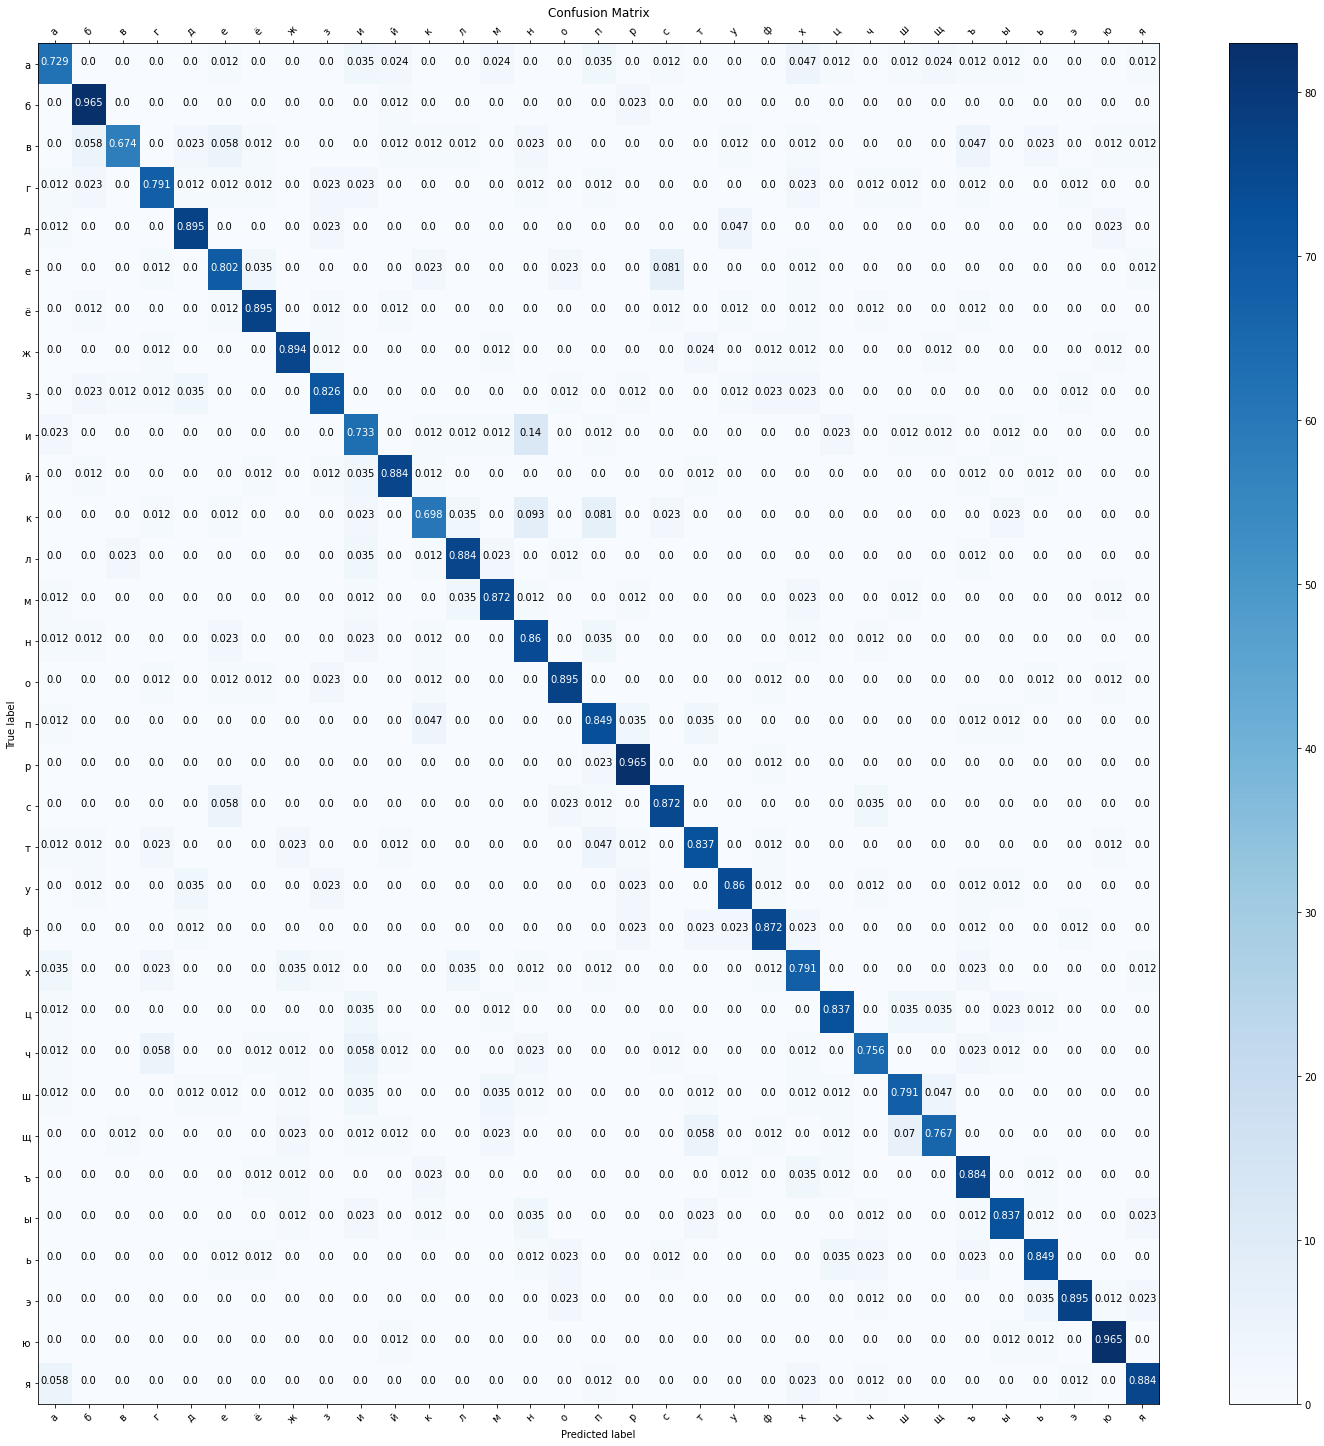

In [74]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

y_pred = cnn_model.predict(X_val)
y_pred = np.argmax(y_pred,axis=1)
cm = confusion_matrix(y_true=np.argmax(y_val,axis=1), y_pred=y_pred)


def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
    plt.figure(figsize = (20,20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],3)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



cm_plot_labels = ["а","б", "в","г","д","е","ё","ж","з","и","й","к","л","м", "н","о","п",
"р","с","т", "у","ф","х","ц","ч", "ш","щ", "ъ","ы","ь","э","ю","я"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix', normalize=True)
